In [13]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground, MADStdBackgroundRMS
from photutils.utils import make_random_cmap
from matplotlib.colors import LogNorm

In [14]:
#image_file = 'example_data/PAL5_3p6um.fits'
image_file = 'data/PAL5/PAL5__e1/PAL5__e1_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

EXPTIME: 71.3724
FLUXCONV: 0.1257


In [15]:
mean, median, std = sigma_clipped_stats(data, sigma=4.)
print(std)

13.865745544433594


### Source detection:

101


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


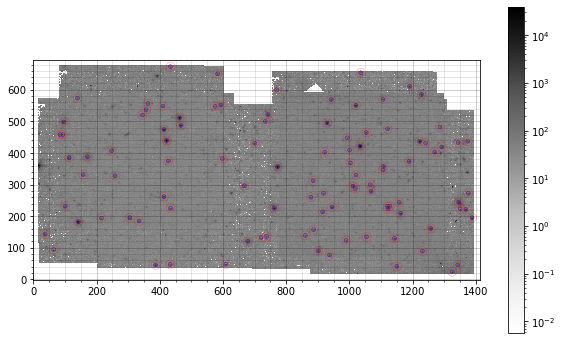

In [16]:
#daofind = DAOStarFinder(threshold=20.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5)
daofind = DAOStarFinder(threshold=50.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5, sharphi = 0.8)
sources = daofind(data)

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.75)
annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_bigbig.png', dpi=500)

print(len(sources))

### Aperture photometry:

In [17]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1325.4233 24.020858            nan            nan
  2 1150.0528 41.601753      20206.612      25412.815
  3 386.74295 45.458175      44326.399            nan
  4  1343.023 45.681609      22347.625      36337.049
  5  432.7817 46.887401      13971.121            nan
  6 609.12078  48.03322      15052.629            nan
  7 937.06686  77.30249      15540.908      22569.242
  8 1231.1472  89.58276      20064.907      28895.706
  9 901.59729 90.255708      34061.296      32349.948
 10 63.841924 94.236844      127452.69      22120.314
...       ...       ...            ...            ...
 92 362.00639 556.44721      15875.894      25030.454
 93 942.60339 569.13864      33203.326      31838.544
 94 1106.5571 569.69594      24538.208      25181.997
 95 139.22387 573.41217      15299.924      25394.047
 96 1228.0371 585.49859     

In [18]:
annulus_masks = annuli.to_mask(method='center')
aperture_correction = 1.125

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]
    _, median_annuli, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_annuli)
    
bkg_median = np.array(bkg_median)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = aperture_correction * (phot_table['aperture_sum_0'] - phot_table['aper_bkg'])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1 1325.4233 24.020858 ...       89.49353  10121.48             nan
  2 1150.0528 41.601753 ...      48.400345   5473.95       16574.245
  3 386.74295 45.458175 ...      48.895529  5529.954           43646
  4  1343.023 45.681609 ...      71.277359 8061.2794       16072.139
  5  432.7817 46.887401 ...      42.088205 4760.0639       10362.439
  6 609.12078  48.03322 ...      37.512127 4242.5216       12161.371
  7 937.06686  77.30249 ...      44.973366 5086.3678       11761.358
  8 1231.1472  89.58276 ...      56.883942 6433.4222        15335.42
  9 901.59729 90.255708 ...      61.189175 6920.3326       30533.584
 10 63.841924 94.236844 ...      39.564987 4474.6946       138350.25
...       ...       ... ...            ...       ...             ...
 92 362.00639 556.44721 ...      4

### Building an ePSF:

In [19]:
cutout_size = 150
#cutout_size = 200    # this whole bit might not work properly, since the image doesn't go all the way to the edges of the graph
hsize = (cutout_size - 1) / 2
x = phot_table['xcenter'].value
y = phot_table['ycenter'].value
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_table = Table()
star_table['x'] = x[mask]
star_table['y'] = y[mask]

print(star_table)

        x                  y         
------------------ ------------------
  937.066861872341  77.30248956008053
1231.1472298580188  89.58276026027542
 901.5972882006813  90.25570810818085
 678.0489555503532 120.67173715491315
 989.4494416136453 123.26729416728504
 1142.619144550548 129.77560803303803
 720.2079852237532  132.4634003379652
 1053.732434551591 134.43565087993028
 738.0365047770222  136.0983658137422
 860.6426896833566  138.9583834327011
               ...                ...
  574.761926651839  547.6221604751732
410.05105267288764  548.4659404044584
 1020.404234995659  550.5950152353512
  593.196291829272  551.7966177588476
 362.0063899035551  556.4472130622395
 942.6033913695115  569.1386413706331
 1106.557059747372  569.6959363567099
139.22386938053972   573.412172401078
1228.0370975029273  585.4985914130496
 769.4841767686548  599.9041351757072
1190.5967492547368  611.1096900817679
Length = 83 rows


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


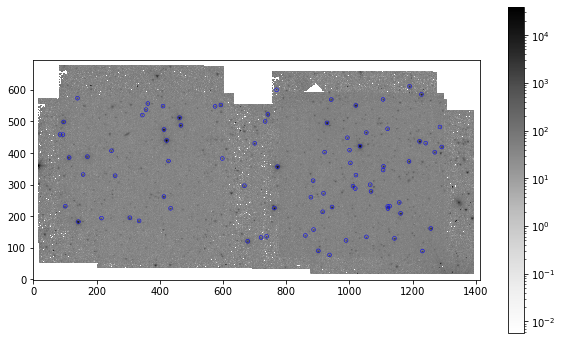

In [20]:
starpos = np.transpose((star_table['x'], star_table['y']))
starap = CircularAperture(starpos, r=6.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5)
plt.gcf().set_size_inches(10, 6)

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


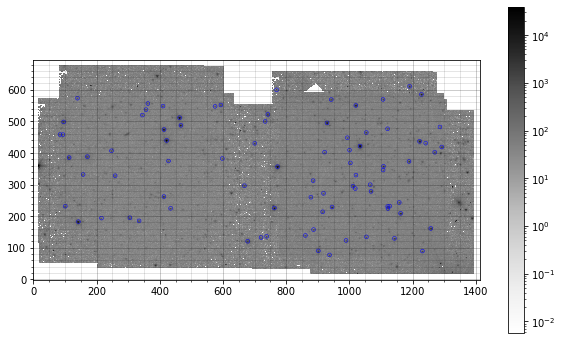

In [21]:
_, median_sub, _ = sigma_clipped_stats(data, sigma=6.) # could use 'median' as above if keeping same sigma

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
starap.plot(color='blue', lw=.5, alpha=1.)
#annuli.plot(color='red', lw=.4, alpha=.5)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

#plt.savefig('images/temp_subdata.png', dpi=500)

10 8 3 83


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


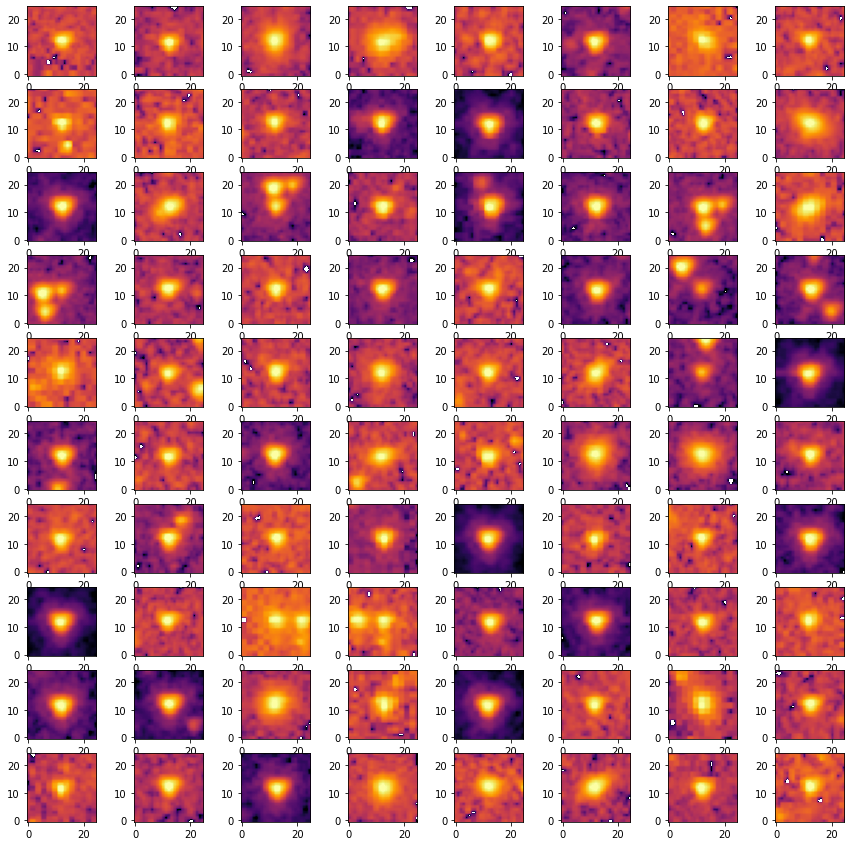

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


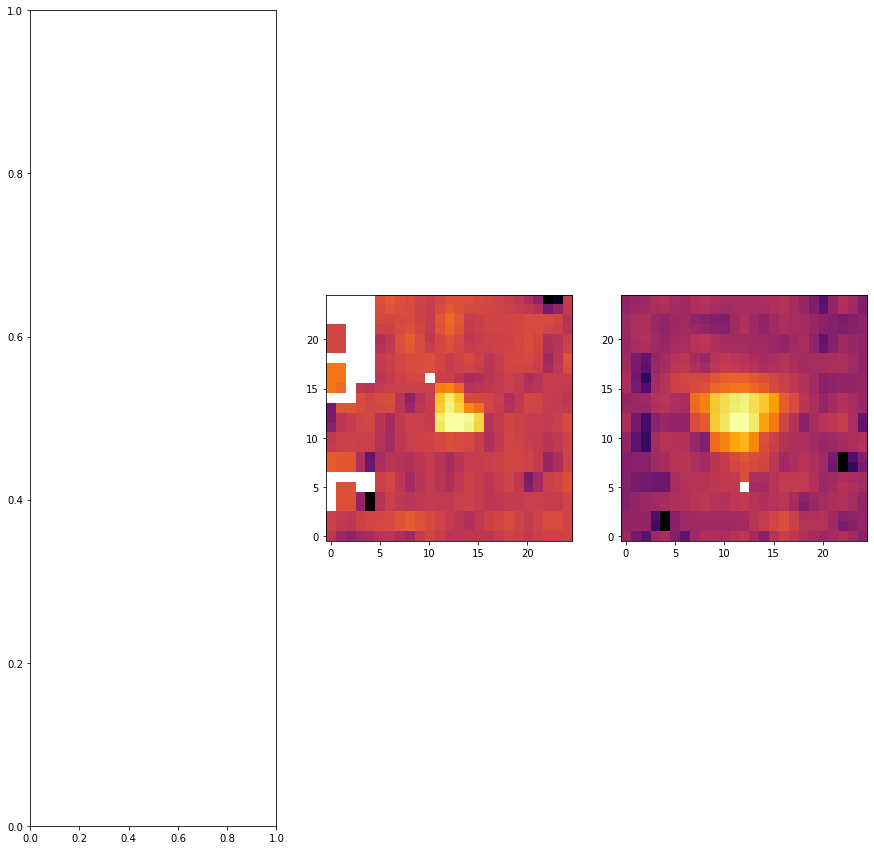

In [22]:
data_sub = data - median_sub

#nddata = NDData(data = data)
nddata = NDData(data = data_sub)
stars = extract_stars(nddata, star_table, size=25)
ncols = 8
nrows = int(np.floor(len(stars) / ncols))
nrem = len(stars) - (nrows*ncols)
print(nrows, ncols, nrem, len(stars))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='inferno')
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=nrem, figsize=(15, 15), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols + 1, len(stars)):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i - nrows*ncols].imshow(stars[i], norm=norm, origin='lower', cmap='inferno')
plt.show()

#fig, ax = plt.subplots(nrows=1, ncols=nrem, figsize=(15, 15), squeeze=True)
#ax = ax.ravel()
#for i in range(nrows*ncols + 1, len(stars)):
#    norm = simple_norm(stars[i], 'log', percent=99.)
#    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='inferno')
#plt.show()

Visualising the ePSF:

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


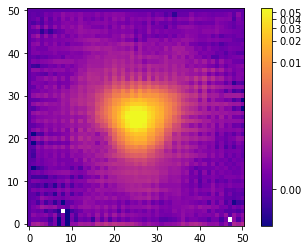

In [23]:
# maxiters = 3 looks good to me, oversampling could either be 3 or 4 (unless we want original resolution)
epsf_builder = EPSFBuilder(oversampling=2, maxiters=10, progress_bar=True)
epsf, fitted_stars = epsf_builder(stars)

norm = simple_norm(epsf.data, 'log', percent=99.)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma')
#plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma', vmin=0.01)
plt.colorbar()

### Beginning PSF photometry:

Re-doing source detection to find more stars:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


495


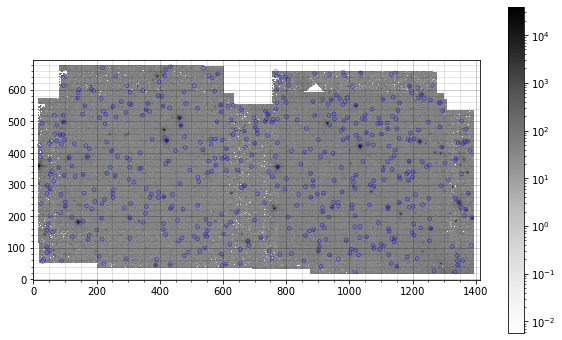

In [24]:
daofind_PSF = DAOStarFinder(threshold=6.*std, fwhm=5., roundlo = -0.5, roundhi = 0.5, sharphi = 0.7) # could use a sigma*gaussian_sigma_to_fwhm instead (see PSF tutorial)
sources_PSF = daofind_PSF(data)

pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
apertures_PSF = CircularAperture(pos_PSF, r=6.)
norm = LogNorm()

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures_PSF.plot(color='blue', lw=.5, alpha=.75)
plt.minorticks_on()
plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
plt.gcf().set_size_inches(10, 6)

plt.savefig('images/psf_01.png', dpi=500)
print(len(sources_PSF))

Grouping stars based on proximity to neighbours:

In [25]:
sources_PSF['xcentroid'].name = 'x_0'
sources_PSF['ycentroid'].name = 'y_0'

fwhm = 5.   # loosely determined using imexam with several stars
daogroup = DAOGroup(crit_separation = 2.5 * fwhm) # from tests, 2.5 - 3ish looks decent; groups stars roughly one aperture apart
star_groups = daogroup(sources_PSF)
star_groups = star_groups.group_by('group_id')
print(star_groups)

 id        x_0                y_0         ...          mag          group_id
--- ------------------ ------------------ ... --------------------- --------
  1 1335.7201430054681 23.327156285941737 ...   -0.2974379727171283        1
  2 1017.0720463541089 24.456138915509573 ...  -0.15475619663801463        2
  3 1267.5653110068354  27.53139597923031 ...   -1.2689624834524658        3
  4  910.4856115760876   40.6448202714618 ...   -0.3994031065859437        4
  5 1150.0528392708088 41.601753304811524 ...   -2.5981790324360468        5
  6  596.7655799588732 43.768450277750745 ...   -1.4637850035108235        6
  7   386.742952879898  45.45817523135233 ...    -4.228235739059396        7
  8 1343.0230028423614  45.68160914373817 ...   -2.9248547767075324        8
  9 432.78170056378406  46.88740144404619 ...   -2.6060253785319003        9
 10  609.1207788692492  48.03321986450478 ...    -3.578005002173828       10
...                ...                ... ...                   ...      ...

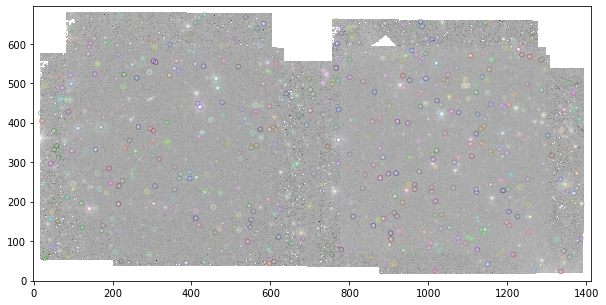

In [26]:
ncolors = max(star_groups['group_id'])
cmap = make_random_cmap(ncolors=ncolors, seed=1612)

plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys_r')
for i, group in enumerate(star_groups.groups):
    pos_group = np.transpose([group['x_0'], group['y_0']])
    ap_group = CircularAperture(pos_group, r=6.)
    ap_group.plot(color=cmap.colors[i], lw=.5)
    
plt.savefig('images/groups_test_03.png', dpi=500)
plt.gcf().set_size_inches(10, 6)
plt.show()

Replacing all NaNs with a float:

(695, 1413)


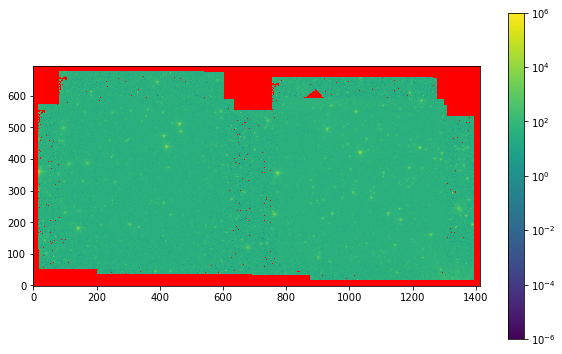

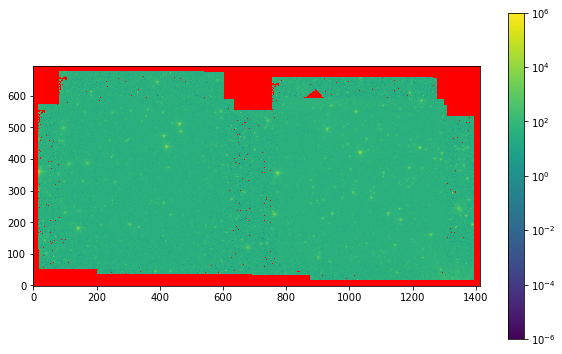

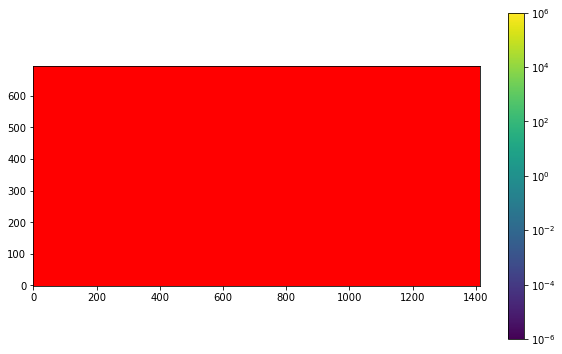

[[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 ...
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
 [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [27]:
current_cmap = matplotlib.cm.get_cmap()
current_cmap.set_bad(color='red')

test = np.nan_to_num(data, nan=0.00001, copy=True)
print(test.shape)
plt.imshow(test, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='viridis', vmin=0.000001, vmax=10**6)
plt.colorbar()
plt.gcf().set_size_inches(10, 6)
plt.show()
plt.close()

plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='viridis', vmin=0.000001, vmax=10**6)
plt.colorbar()
plt.gcf().set_size_inches(10, 6)
plt.show()
plt.close()

plt.imshow(data - test, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='viridis', vmin=0.000001, vmax=10**6)
plt.colorbar()
plt.gcf().set_size_inches(10, 6)
plt.show()
plt.close()

print(test[0:50, 0:50])
print(data[0:50, 0:50])
print(data[0:50, 0:50] - test[0:50, 0:50])

***psf_model***: 'epsf' should already be in right format (EPSFModel class) for ISPSF, see very bottom of photutils' ePSF page

***aperture_radius***: need to specify, as FWHM probably can't be found from ePSF (could try as 6pix like central apertures, or the same as FWHM, 5pix)

In [28]:
bkg_estimation = MMMBackground()  # same as SKY in DAOPHOT; ie. the mode of the bkg
fitter = LevMarLSQFitter()

PSF_photometry = ISPSF(finder = daofind_PSF,
                      group_maker = daogroup,
                      bkg_estimator = bkg_estimation,
                      psf_model = epsf,
                      fitter = fitter,
                      fitshape = 13,   # eg. 13 -> fits at pixels -6,-5,...,5,6 in x and y
                      niters = 1,
                      aperture_radius = 6.)  
result = PSF_photometry(image = test)
residual_image = PSF_photometry.get_residual_image()

#print(fit_info['message'])

C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in less
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:716: RuntimeWarning: invalid value encountered in greater
  invalid = (((xi < 0) | (xi > (self._nx - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in less
  ((yi < 0) | (yi > (self._ny - 1)
C:\Users\Jake\anaconda3\lib\site-packages\photutils\psf\models.py:718: RuntimeWarning: invalid value encountered in greater
  ((yi < 0) | (yi > (self._ny - 1)


In [29]:
#print(self.fit_info['message'])

In [30]:
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])
#hdul.writeto('outputs/residual_01.fits', overwrite=True)

print(residual_image[0:100, 0:100])

[[-46.490128   -46.490128   -46.490128   ... -46.490128   -46.490128
  -46.490128  ]
 [-46.490128   -46.490128   -46.490128   ... -46.490128   -46.490128
  -46.490128  ]
 [-46.490128   -46.490128   -46.490128   ... -46.490128   -46.490128
  -46.490128  ]
 ...
 [-46.490128   -46.490128   -46.490128   ...  -0.82084274  -3.61232
   -8.335728  ]
 [-46.490128   -46.490128   -46.490128   ...  14.287533    12.248028
   -6.709484  ]
 [-46.490128   -46.490128   -46.490128   ...  10.286182     8.2271
   -2.6662483 ]]


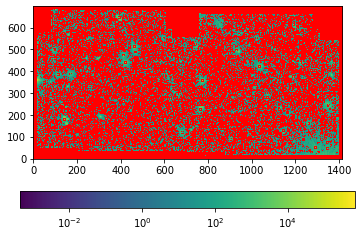

In [38]:
res_file = 'outputs/residual_01.fits'
res_data = fits.getdata(res_file, ext=0)
plt.imshow(res_data, cmap='viridis', origin='lower', norm=LogNorm(), interpolation='nearest')
plt.colorbar(orientation='horizontal')

Viewing the residual image:

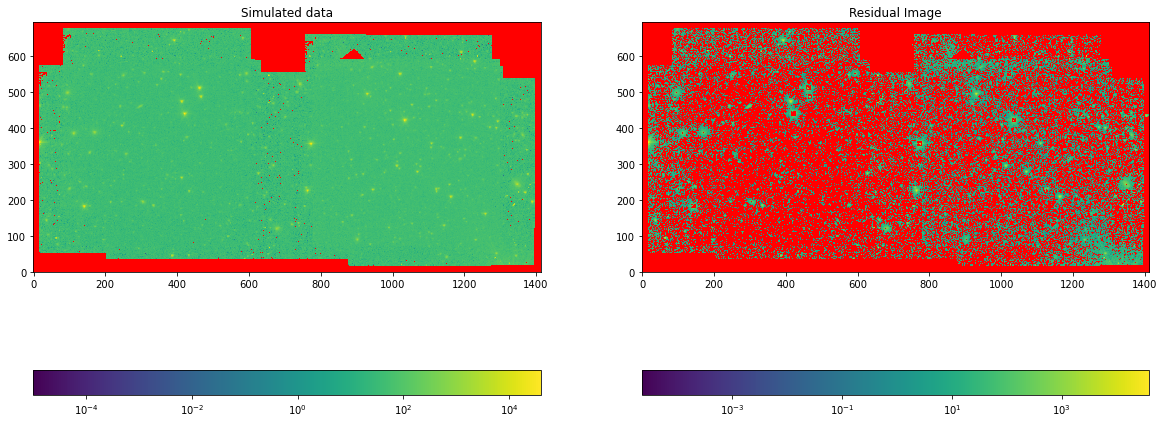

In [39]:
current_cmap = matplotlib.cm.get_cmap()
#current_cmap = 'viridis'
current_cmap.set_bad(color='red')

plt.subplot(1, 2, 1)
plt.imshow(test, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Simulated data')
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.imshow(residual_image, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual Image')
plt.colorbar(orientation='horizontal')

plt.gcf().set_size_inches(20, 12)
#plt.show()

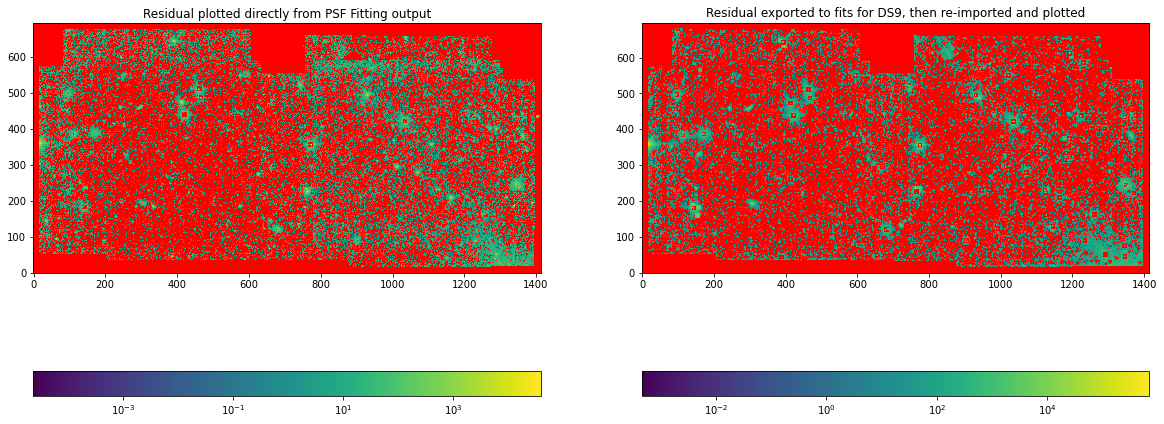

In [40]:
plt.subplot(1, 2, 1)
plt.imshow(residual_image, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual plotted directly from PSF Fitting output')
plt.colorbar(orientation='horizontal')

plt.subplot(1, 2, 2)
plt.imshow(res_data, cmap='viridis', interpolation='nearest', origin='lower', norm=LogNorm())
plt.title('Residual exported to fits for DS9, then re-imported and plotted')
plt.colorbar(orientation='horizontal')

plt.gcf().set_size_inches(20, 12)
plt.savefig('images/residual_bastards.png', dpi=200)

In [41]:
print(result['id', 'group_id', 'iter_detected', 'x_0', 'y_0'])
print(result['flux_0', 'x_fit', 'y_fit', 'flux_fit'])

 id group_id iter_detected        x_0                y_0        
--- -------- ------------- ------------------ ------------------
  1        1             1 1116.1600062853895 19.381458345712726
  2        2             1  1251.097904664328 20.828736341776676
  3        3             1 1335.7201429450326 23.327156254893474
  4        4             1 1267.5653110012124 27.531395981192755
  5        5             1   910.485611581015  40.64482025012572
  6        6             1 1150.0528392498431  41.60175329978901
  7        7             1  596.7655799522051  43.76845028015125
  8        8             1 386.74295289864716  45.45817522526471
  9        9             1 1343.0230028405913 45.681609139475654
 10       10             1  432.7817005501641  46.88740147193583
...      ...           ...                ...                ...
524      457             1  419.5736332895033  664.8068867939771
525      458             1  538.2202566100304   667.987227029822
532      458             

72


C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


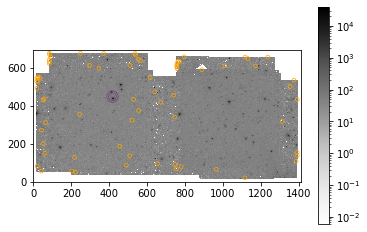

In [42]:
negatives = []
fail_x_0 = []
fail_y_0 = []
fail_x_fit = []
fail_y_fit = []

for i in range(len(result)):
    if result['flux_0'][i] < 0.:
        negatives.append(result['flux_0'][i])
        fail_x_0.append(result['x_0'][i])
        fail_y_0.append(result['y_0'][i])
    elif result['flux_fit'][i] < 0.:
        fail_x_fit.append(result['x_fit'][i])
        fail_y_fit.append(result['y_fit'][i])

#print(negatives)
print(len(negatives))

fails_0 = np.column_stack((fail_x_0, fail_y_0))
fails_fit = np.column_stack((fail_x_fit, fail_y_fit))
bad_apples_0 = CircularAperture(fails_0, r=10.)
bad_apples_fit = CircularAnnulus(fails_fit, r_in=20., r_out=30.)

plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
bad_apples_0.plot(color='orange', lw=.7, alpha=1.)
bad_apples_fit.plot(color='purple', lw=.4, alpha=1.)

#plt.savefig('images/psf_fails_01.png', dpi=500)

In [43]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
conv = fluxconv / exptime
negative_sums = []

result['apparent_mag'] = float('NaN')

for i in range(0, len(result)):
    if result['flux_fit'][i] >= 0:
        result['apparent_mag'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * result['flux_fit'][i])
    else:
        negative_sums.append(result['id'][i])

for col in result.colnames:
    result[col].info.format = '%.8g'
print(result['id', 'x_0', 'y_0', 'flux_fit', 'apparent_mag'])
#print(negative_sums)

print(np.count_nonzero(~np.isnan(result['apparent_mag'])))

 id    x_0       y_0     flux_fit apparent_mag
--- --------- --------- --------- ------------
  1   1116.16 19.381458 182.70892    19.903207
  2 1251.0979 20.828736 978.45393    18.081255
  3 1335.7201 23.327156 2806.6416    16.937139
  4 1267.5653 27.531396 3268.2308    16.771824
  5 910.48561  40.64482 1105.5026    17.948707
  6 1150.0528 41.601753 11798.506    15.378039
  7 596.76558  43.76845 2887.0439    16.906473
  8 386.74295 45.458175 42628.384    13.983359
  9  1343.023 45.681609 14389.619    15.162483
 10  432.7817 46.887401  9032.794    15.668051
...       ...       ...       ...          ...
524 419.57363 664.80689 3119.2206    16.822491
525 538.22026 667.98723 420.89947     18.99716
532 536.28286 675.02263 343.88761    19.216565
526  109.3574 669.03723 728.10357    18.402123
527 85.027174 670.26923 305.89586    19.343672
533 84.294028 677.09422 517.53159    18.772764
528 218.06522 670.09513 925.05132    18.142192
529 471.15821 670.54358 1122.0316    17.932594
530 433.18189

In [28]:
#plt.hist(result['apparent_mag'], bins=200)

In [29]:
#result['id', 'x_0', 'y_0', 'apparent_mag'].write('outputs/psf_test01.txt', format='csv', overwrite=True)